## Business Objective

1. To understand the impact of markdowns to sales on a per SKU and per transaction/basket level;
2. To understand if markdowns would impact overall store sales;
3. To understand what products tend to respond to markdowns the most, and which ones don't; 
4. To understand cross-sell and up-sell opportunities.


<br>

## Process: 
- <a href='#1'>Look At Data First </a>
 - <a href='#1_1'>How the entire dateset is organized?</a>
 - <a href='#3'>Explore cases when Count=0</a>
 - <a href='#4'>Explore cases when Count=-1</a>
 - <a href='#1_2'>How many different behaviors we can observe within a transaction?</a>
- <a href='#2'>Cleaning Dirty Data and Finding Outliers </a>
 - <a href='#6'>Create a column indicating whether a SKU is a regular return, orphan return</a> **(Check 'Return Types.ipynb')**
 - <a href='#7'>Check Missing Values</a>
 - <a href='#8'>Explore Anomalies</a>
  - <a href='#81'>Calculate Discount Rate on a per transaction and per sku basis </a> **(Check 'Discount Rate.ipynb')**
 - <a href='#82'>Explore Outliers</a>
- <a href='#80'>Exploratory Data Analysis</a>  **(Check 'EDA.ipynb')**
- <a href='#90'>Actual Analysis </a>
 - <a href='#110'>1. How promotion strategy impacts sales on a per store basis? </a>
 - <a href='#10'>2. If a product is discounted across different stores, how are you going to evaluate the promotion strategy?</a>
 - <a href='#11'>3. Can we find any cross-sell and up-sell opportunites?</a>
 - <a href='#12'>4. How about the time or day of promotion? Would that make a difference?</a>
 - <a href='#13'>5. Look at low end and high end products separately when evaluating promotion strategy</a>
 
 




<br>

## Look At Data First	<a name='1' />


In [1]:
import pandas as pd
from datetime import datetime

In [12]:
start_time = datetime.now()
data = pd.read_csv('RetailerPromotionStrategy_data.csv')
print datetime.now()-start_time

0:00:01.360275


In [74]:
data.head()

,StoreID,TransactionID,Line,Sales,Count,Date,SKU
0,A29,11-7270-00007-00057,36,850.0,1.0,3/11/12 00:00,A21773
1,A29,11-7270-00007-00057,39,1500.0,1.0,3/11/12 00:00,A18009
2,A29,11-7270-00007-00057,40,1500.0,1.0,3/11/12 00:00,A25592
3,A29,11-7270-00007-00057,41,1600.0,1.0,3/11/12 00:00,A1449
4,A29,11-7270-00007-00057,42,1600.0,1.0,3/11/12 00:00,A1449


### How is the entire dateset  organized? <a name='1_1' />

In [14]:
print 'Shape of dataset: {0}'.format(data_type.shape)
print 'Number of unique stores: {0}'.format(len(data_type.StoreID.unique()))
print 'Number of unique transactions: {0}'.format(len(data_type.TransactionID.unique()))
print 'Number of unique dates: {0}'.format(len(data_type.Date.unique()))
print 'Number of unique SKUs: {0}'.format(len(data_type.SKU.unique()))

Shape of dataset: (1041577, 8)
Number of unique stores: 73
Number of unique transactions: 192963
Number of unique dates: 2
Number of unique SKUs: 15179


- There are total 1M rows and 7 features in the dataset. 
- There are 73 unique stores, 15K unique SKUs, and 200K unique transactions.
- The records are organized on a SKU level by each transaction within each store, for each day.


### Explore cases when Count=0 <a name='3' />

In [42]:
data_count0 = data[data['Count']==0]

data_count0.head(3)

,StoreID,TransactionID,Line,Sales,Count,Date,SKU
12,A29,11-7270-00007-00057,63,-786.0,0.0,3/11/12 00:00,A256
14,A29,11-7270-00007-00057,65,-770.0,0.0,3/11/12 00:00,A8481
20,A29,11-7270-00007-00057,75,-500.0,0.0,3/11/12 00:00,A2341


In [24]:
data.loc[(data['SKU']=='A256')&(data['TransactionID']=='11-7270-00007-00057')]

,StoreID,TransactionID,Line,Sales,Count,Date,SKU
11,A29,11-7270-00007-00057,62,2095.0,1.0,3/11/12 00:00,A256
12,A29,11-7270-00007-00057,63,-786.0,0.0,3/11/12 00:00,A256


When Count=0, it means it's a discount applied to the purchase

In [23]:
# Why there are rows where Count=0 but Sales>0?
data.loc[(data['Count']==0)&(data['Sales']>0)].head(3)

,StoreID,TransactionID,Line,Sales,Count,Date,SKU
1161,A29,11-7270-00007-00110,29,845.0,0.0,3/11/12 00:00,A6007
1234,A29,11-7270-00007-00116,20,234.0,0.0,3/11/12 00:00,A2452
4065,A29,11-7270-00008-00358,6,670.0,0.0,3/11/12 00:00,A13774


In [22]:
data[(data.TransactionID=='11-7270-00007-00110')&(data.SKU=='A6007')][4:]

,StoreID,TransactionID,Line,Sales,Count,Date,SKU
1158,A29,11-7270-00007-00110,26,2195.0,1.0,3/11/12 00:00,A6007
1159,A29,11-7270-00007-00110,27,-845.0,0.0,3/11/12 00:00,A6007
1160,A29,11-7270-00007-00110,28,-2195.0,-1.0,3/11/12 00:00,A6007
1161,A29,11-7270-00007-00110,29,845.0,0.0,3/11/12 00:00,A6007


We know from the above table: The positive sales amount is basically the credit back to the store for the discount extended to the customer earlier.

### Explore cases when Count=-1 <a href='#4'>

In [66]:
# Count=-1
data.loc[data['Count']==-1].head()

,StoreID,TransactionID,Line,Sales,Count,Date,SKU
100,A29,11-7270-00007-00066,5,-2013.000,-1.000,3/11/12 00:00,A2729
354,A19,11-7287-00025-00075,4,-1721.000,-1.000,3/11/12 00:00,A16911
446,A27,11-7069-00020-00010,6,-4252.000,-1.000,3/11/12 00:00,A7293
458,A29,11-7270-00007-00072,37,-2395.000,-1.000,3/11/12 00:00,A19365
622,A29,11-7270-00007-00089,19,-3995.000,-1.000,3/11/12 00:00,A21166


In [19]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [26]:
q = '''
    select
        d1.StoreID, d1.TransactionID, d1.Line, d1.Sales, d1.Count, d1.Date, d1.SKU
    from 
        data d1
    inner join
        (select 
            TransactionID, SKU
        from
            data
        where Count=-1) as d2
    on 
        d1.TransactionID = d2.TransactionID and
        d1.SKU = d2.SKU
    '''
data2 = pysqldf(q)

In [27]:
data2.head(10)

,StoreID,TransactionID,Line,Sales,Count,Date,SKU
0,A29,11-7270-00007-00066,3,2013.0,1.0,3/11/12 00:00,A2729
1,A29,11-7270-00007-00066,4,2013.0,1.0,3/11/12 00:00,A2729
2,A29,11-7270-00007-00066,5,-2013.0,-1.0,3/11/12 00:00,A2729
3,A19,11-7287-00025-00075,3,1721.0,1.0,3/11/12 00:00,A16911
4,A19,11-7287-00025-00075,4,-1721.0,-1.0,3/11/12 00:00,A16911
5,A27,11-7069-00020-00010,1,4252.0,1.0,3/11/12 00:00,A7293
6,A27,11-7069-00020-00010,6,-4252.0,-1.0,3/11/12 00:00,A7293
7,A29,11-7270-00007-00072,33,2395.0,1.0,3/11/12 00:00,A19365
8,A29,11-7270-00007-00072,35,2395.0,1.0,3/11/12 00:00,A19365
9,A29,11-7270-00007-00072,36,2395.0,1.0,3/11/12 00:00,A19365


We can see from the table, ‘count=-1’ means the customer returned the item just bought or it could be a promotion strategy like buy 1 get 1 free. In this analysis, I treated it as a return.


<br><br>

## Cleaning Dirty Data and Finding Outliers <a name='2'/>

### Create a column indicating whether a SKU is a regular return, orphan return<a name='6' />

Please **check 'Return Types.ipynb'** to see how I sorted out regular returns and orphan returns. And then I create a new column next to the raw dataset and indicate whether a SKU is a regular return, orphan return, regular return credit back, or orphan return credit back. This will allow us to easily manipulate the records on a row level, SKU level, or transaction level, depending on what our analysis needs are. 


**Description**
1. When Sales is negative and Count=0, then it's a discount.
2. When Sales is negative, Count is negative, and there are matching purchase within the same transaction, then it's a regular return.
3. When Sales is negative, Count is negative, and there are no matching purchase within the same transaction, then it's an orphan return.
4. When Sales is positve and Count=0, then it's part of return of a credit back to this store of a discounted item


In [29]:
data_type = pd.read_csv('type.csv')
data_type.fillna('',inplace=True)

In [302]:
data_type.shape

(1048575, 8)

In [303]:
data_type[data_type.TransactionID=='11-7270-00007-00066'][:4]

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
97,A29,11-7270-00007-00066,1,300.000,1.000,3/11/12 00:00,A21771,
98,A29,11-7270-00007-00066,3,2013.000,1.000,3/11/12 00:00,A2729,
99,A29,11-7270-00007-00066,4,2013.000,1.000,3/11/12 00:00,A2729,
100,A29,11-7270-00007-00066,5,-2013.000,-1.000,3/11/12 00:00,A2729,Regular_Return


In [304]:
data_type[data_type.TransactionID=='11-7270-00012-00154']

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
5035,A29,11-7270-00012-00154,2,-17475.000,-5.000,3/11/12 00:00,A6386,Orphan_Return
5036,A29,11-7270-00012-00154,3,10000.000,5.000,3/11/12 00:00,A6386,


In [30]:
data_type[(data_type.TransactionID=='12-7081-00015-00118')&(data_type.SKU=='A5483')]

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
485387,A33,12-7081-00015-00118,2,-33990.0,-2.0,3/12/12 00:00,A5483,Orphan_Return
485388,A33,12-7081-00015-00118,3,21000.0,0.0,3/12/12 00:00,A5483,CreditBack_OrphanReturn
485390,A33,12-7081-00015-00118,5,-16995.0,-1.0,3/12/12 00:00,A5483,Orphan_Return
485391,A33,12-7081-00015-00118,6,10500.0,0.0,3/12/12 00:00,A5483,CreditBack_OrphanReturn
485393,A33,12-7081-00015-00118,9,6495.0,1.0,3/12/12 00:00,A5483,
485394,A33,12-7081-00015-00118,10,-16995.0,-1.0,3/12/12 00:00,A5483,Orphan_Return


<br><br>

### Check Missing Values <a name='7' />

In [31]:
data_type.isnull().sum()

StoreID          0
TransactionID    0
Line             0
Sales            0
Count            0
Date             0
SKU              0
Type             0
dtype: int64

<br><br>

### Explore Anomalies <a name='8' />

In [192]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
data_type.describe()

,Line,Sales,Count
count,1048575.000,1048575.000,1048575.000
mean,10.727,1720.513,0.896
std,15.550,3646.003,1.129
min,1.000,-99995.000,-120.000
25%,3.000,395.000,1.000
50%,7.000,1295.000,1.000
75%,14.000,2195.000,1.000
max,823.000,99995.000,120.000


#### Scenario 1: When count is a decimal point and sales=0


In [193]:
data_type[(data_type.Sales==0) & (data_type.Count<1) & (data_type.Count>0)]

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
19710,A65,11-3571-00002-00495,7,0.000,0.020,3/11/12 00:00,A10522,
20406,A65,11-3571-00001-00205,22,0.000,0.020,3/11/12 00:00,A10522,
99018,A06,12-6997-00005-00028,3,0.000,0.010,3/12/12 00:00,A4945,
816024,A65,12-3572-00001-00033,15,0.000,0.020,3/12/12 00:00,A10522,
817574,A65,12-3572-00001-00305,9,0.000,0.020,3/12/12 00:00,A10522,


In [305]:
data_type.drop(data_type[(data_type.Sales==0) & (data_type.Count<1) & (data_type.Count>0)].index,inplace=True)

There are 5 rows where count is a decimal point and sales=0.    
Treatment: We can safely filter these rows out from our analysis.

<br>

#### Scenario 2: When Count=0 and Sales=0

In [195]:
data_type[(data_type.Sales==0) & (data_type.Count==0)].head(2)

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
387,A27,11-7069-00019-00010,3,0.000,0.000,3/11/12 00:00,A25083,
388,A27,11-7069-00019-00010,4,0.000,0.000,3/11/12 00:00,A14671,


In [196]:
data_type[(data_type.Sales==0) & (data_type.Count==0)].shape

(3223, 8)

In [306]:
data_type.drop(data_type[(data_type.Sales==0) & (data_type.Count==0)].index,inplace=True)

There are 3223 rows where count=0 and sales=0.    
Treatment: We can safely filter these rows out from our analysis.

<br>

#### Scenario 3: Orphan Return - returns with no matching purchase within the same transaction 

In [220]:
data_type[(data_type.TransactionID=='11-7270-00012-00190')]

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
5050,A29,11-7270-00012-00190,1,-18995.000,-1.000,3/11/12 00:00,A10981,Orphan_Return
5051,A29,11-7270-00012-00190,2,-7995.000,-1.000,3/11/12 00:00,A21473,Orphan_Return


In [221]:
data_type[(data_type.TransactionID=='12-7081-00015-00118')&(data_type.SKU=='A5483')]

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
485387,A33,12-7081-00015-00118,2,-33990.000,-2.000,3/12/12 00:00,A5483,Orphan_Return
485388,A33,12-7081-00015-00118,3,21000.000,0.000,3/12/12 00:00,A5483,CreditBack_OrphanReturn
485390,A33,12-7081-00015-00118,5,-16995.000,-1.000,3/12/12 00:00,A5483,Orphan_Return
485391,A33,12-7081-00015-00118,6,10500.000,0.000,3/12/12 00:00,A5483,CreditBack_OrphanReturn
485393,A33,12-7081-00015-00118,9,6495.000,1.000,3/12/12 00:00,A5483,
485394,A33,12-7081-00015-00118,10,-16995.000,-1.000,3/12/12 00:00,A5483,Orphan_Return


In [307]:
orphan = data_type[(data_type.Type=='Orphan_Return')|(data_type.Type=='CreditBack_OrphanReturn')]

In [235]:
orphan.head()

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
5003,A29,11-7270-00012-00113,2,-17990.000,-2.000,3/11/12 00:00,A22728,Orphan_Return
5021,A29,11-7270-00012-00126,1,-3500.000,-1.000,3/11/12 00:00,A24521,Orphan_Return
5035,A29,11-7270-00012-00154,2,-17475.000,-5.000,3/11/12 00:00,A6386,Orphan_Return
5040,A29,11-7270-00012-00167,2,-54000.000,-1.000,3/11/12 00:00,A1149,Orphan_Return
5045,A29,11-7270-00012-00174,2,-11985.000,-3.000,3/11/12 00:00,A25628,Orphan_Return


In [236]:
print data_type.shape
print orphan.shape
print len(orphan.TransactionID.unique())

(1045347, 8)
(3651, 8)
2813


In [308]:
# Drop rows with orphan returns
data_type = pd.merge(data_type,orphan,on=['StoreID','TransactionID','Line','Sales','Count','Date','SKU','Type'],how='left',indicator=True)
data_type = data_type[data_type['_merge']=='left_only']

In [309]:
data_type.drop('_merge',1,inplace=True)

In [264]:
data_type.head(3)

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
0,A29,11-7270-00007-00057,36,850.000,1.000,3/11/12 00:00,A21773,
1,A29,11-7270-00007-00057,39,1500.000,1.000,3/11/12 00:00,A18009,
2,A29,11-7270-00007-00057,40,1500.000,1.000,3/11/12 00:00,A25592,


In [265]:
data_type.shape

(1041696, 8)

There are 3651 rows exhibit orphan returns(include credit back for orphan returns) and 2813 transactions exhibit orphan return.  

Treatment: Everytime, when there is an orphan return, we simply exclude them when calculating sales per transaction. If it is a regular return, we leave them be as they will cancel each other out.

<br><br>

#### Scenario 4: When Regular Price equals to the Discount Price on SKU level within a store

Treatment: There are 319 records exhibited this behavior, we decided to filter them out.

In [339]:
data_type[(data_type.StoreID=='A65')&(data_type.SKU=='A20997')].head()

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
14494,A65,11-3571-00002-00172,4,2499.000,1.000,3/11/12 00:00,A20997,
821957,A65,12-3572-00002-00070,5,2995.000,1.000,3/12/12 00:00,A20997,
821958,A65,12-3572-00002-00070,6,-496.000,0.000,3/12/12 00:00,A20997,
821959,A65,12-3572-00002-00070,7,2995.000,1.000,3/12/12 00:00,A20997,
821960,A65,12-3572-00002-00070,8,-496.000,0.000,3/12/12 00:00,A20997,


In [ ]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [340]:
# Select transactions with discounted items for each SKU within each Store
q = '''
    select
        a.*
    from
        data_type a
    join
       (select distinct TransactionID, SKU from data_type where Count=0) b
    on
        a.TransactionID=b.TransactionID and a.SKU=b.SKU
    order by 
        a.StoreID, a.SKU
    '''
data40 = pysqldf(q)

In [341]:
# Calcualte discount Price for each SKU within a transaction
q = '''
    select
        distinct StoreID, SKU, sum(Sales)/sum(Count) as 'Discount_Price'
    from
        data40
    group by 
        TransactionID, SKU  
    order by 
        StoreID, SKU
    '''
data41 = pysqldf(q)

In [343]:
data41.head()

,StoreID,SKU,Discount_Price
0,A01,A10074,1738.000
1,A01,A10074,1659.000
2,A01,A1009,1400.000
3,A01,A10142,1750.000
4,A01,A10163,1400.000


In [342]:
# Select transactions without discounted items for each SKU within each Store
q='''
    select
        a.*
    from 
        data_type a
    left join
        data40 b
    on 
        a.TransactionID=b.TransactionID and a.SKU=b.SKU 
    where 
        b.TransactionID is null
    order by
        a.StoreID, a.SKU
  '''
data42=pysqldf(q)

In [344]:
# Calcualte regular Price for each SKU within a transaction

q = '''
    select
        StoreID, TransactionID, SKU, sum(Sales)/sum(Count) as 'Regular_Price'
    from
        data42
    group by 
        TransactionID, SKU  
    order by 
        StoreID, TransactionID, SKU
    '''
data43 = pysqldf(q)

In [345]:
data43.head()

,StoreID,TransactionID,SKU,Regular_Price
0,A01,12-7149-00001-00002,A17071,2995.000
1,A01,12-7149-00001-00002,A24208,1100.000
2,A01,12-7149-00001-00002,A24785,1100.000
3,A01,12-7149-00001-00002,A7050,1450.000
4,A01,12-7149-00001-00003,A3709,1000.000


In [346]:
q = '''
    select
        b.*
    from
        data41 a
    join
        data43 b
    on
        a.StoreID=b.StoreID and a.SKU=b.SKU and a.Discount_Price=b.Regular_Price
    '''
data44 = pysqldf(q)

In [348]:
#Find out transactions when regular_price=discount_price on SKU level within a store
data44.head()

,StoreID,TransactionID,SKU,Regular_Price
0,A01,12-7149-00002-00693,A7257,1250.000
1,A03,12-0856-00004-00379,A1190,1250.000
2,A03,12-0856-00027-00039,A1190,1250.000
3,A03,12-0856-00011-00092,A18742,1250.000
4,A03,12-0856-00004-00379,A20630,1250.000


In [349]:
data44.shape

(237, 4)

In [350]:
# Filter out those records where regular price equals to the discount price on SKU level within a store
q = '''
    select
        a.*
    from
        data_type a
    left join
        data44 b
    on
        a.TransactionID=b.TransactionID and a.SKU=b.SKU and a.Sales/a.Count=b.Regular_Price
    where 
        b.TransactionID is null
    '''
data_type = pysqldf(q)

In [391]:
data_type = data_type.drop(data_type.index[[14488,511618]])

In [411]:
data_type = data_type.drop(data_type.index[[748211,727948]])

In [412]:
data_type.to_csv('data_type.csv', sep=',',index=False)

<br><br>

### Calculate Discount Rate on a per transaction and per sku basis <a name='81' />

Discount rate is calculated on a per SKU basis for each trasaction. (**Check 'Discount Rate.ipynb'**)  

Within each transaction, total sales per SKU can't be negative. With that in mind, we can just filter out those outliers, and the rest, just keep them there as we have no reference as to whether a steep discount rate such as 85% is valid. For now, let's assume they are.



In [2]:
import pandas as pd

In [2]:
data_type = pd.read_csv('data_type.csv')
data_type.fillna('',inplace=True)

In [3]:
data_type.shape

(1041577, 8)

In [4]:
data_type.head(3)

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
0,A29,11-7270-00007-00057,36,850.0,1.0,3/11/12 00:00,A21773,
1,A29,11-7270-00007-00057,39,1500.0,1.0,3/11/12 00:00,A18009,
2,A29,11-7270-00007-00057,40,1500.0,1.0,3/11/12 00:00,A25592,


<br><br>

### Explore Outliers <a name='82' />

In [314]:
df = data_type[data_type.Count>0]
df['Unit Price'] = df['Sales'] / df['Count']

/Users/Frank/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [315]:
df.describe()

,Line,Sales,Count,Unit Price
count,867714.000,867714.000,867714.000,867714.000
mean,10.252,2298.513,1.097,2208.372
std,14.552,3532.143,1.101,3309.162
min,1.000,1.000,1.000,0.015
25%,2.000,895.000,1.000,821.000
50%,6.000,1595.000,1.000,1502.000
75%,13.000,2495.000,1.000,2413.000
max,822.000,99995.000,120.000,99995.000


In [316]:
# Check outliers as a reference
import numpy as np
def find_outliers_tukey(x):
    q1 = np.percentile(x,25)
    q3 = np.percentile(x,75)
    iqr = q3 - q1
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor) | (x > ceiling)])
    outlier_values = list(x[outlier_indices])
    
    return outlier_indices, outlier_values

In [317]:
# Outliers on SKU level
np.set_printoptions(formatter={'float_kind':lambda x: "%.2f" % x})
outlier_var = ['Unit Price']
for x in outlier_var:
    tukey_indices, tukey_values = find_outliers_tukey(df[x])
    a = np.sort(tukey_values)
    print "Feature '{0}' outliers (part)：{1} & {2}\n".format(x,np.unique(a)[:10],np.unique(a)[-10:])
    print "Number of outliers: {0}\n".format(len(tukey_values))

Feature 'Unit Price' outliers (part)：[4810.00 4813.00 4833.00 4835.00 4845.00 4850.00 4875.00 4895.00 4896.00
 4900.00] & [74900.00 79900.00 80000.00 84995.00 85900.00 86900.00 89900.00 94900.00
 99900.00 99995.00]

Number of outliers: 67154



In [318]:
data_type[data_type.TransactionID=='11-7270-00007-00223']

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
4793,A29,11-7270-00007-00223,1,99900.000,1.000,3/11/12 00:00,A21288,
6491,A29,11-7270-00007-00223,11,6303.000,1.000,3/11/12 00:00,A25455,
6492,A29,11-7270-00007-00223,12,725.000,1.000,3/11/12 00:00,A16206,


**Treatment:** Leave outliers there as there is no reference for us to say they are not valid, so let's just assume they are.

<br><br>

## Exploratory Data Analysis <a name='80'/>

Please check **'EDA.ipynb'**

<br><br>

## Actual Analysis <a name='90'/>

### 1. How promotion strategy impacts sales on a per store basis? <a name='110' />

**Metrics:** Average sales per basket on transactions with and without discounts for each STORE

**Calculation Method:** For each store, calculate 'Sum of sales / number of transactions' for transactions with discounted items, and transactions where there are no discounts. (when there is an orphan return, we simply exclude them when calculating sales per transaction). Then we pick top 10 Stores tht exhibited highest changest based on average sales per basket with and without discounts.


In [352]:
# Select transactions with discounted items 
q='''
  select
      a.*
  from
      data_type a
  inner join
      (select distinct TransactionID
       from data_type
       where Count=0) b
  on
      a.TransactionID=b.TransactionID 
  '''
data50= pysqldf(q)

In [353]:
#Drop transactions with discounts
data52 = pd.merge(data_type,data50,on=['StoreID','TransactionID','Line','Sales','Count','Date','SKU','Type'],how='left',indicator=True)
data52 = data52[data52['_merge']=='left_only']
data52.drop('_merge',1,inplace=True)

In [354]:
print data_type.shape
print data50.shape
print data52.shape
print len(data51.TransactionID.unique())
print len(data52.TransactionID.unique())

(1041258, 8)
(636660, 8)
(404598, 8)
61078
131812


In [355]:
# Select transactions with discounted items for specific store
q='''
  select
      StoreID,
      sum(Sales) as Total,
      count(distinct TransactionID) as Number_of_Transactions,
      sum(Sales)/count(distinct TransactionID) as 'Average sales per basket (with discounts)'
  from
      data50
  group by
      StoreID
  
  '''
data70= pysqldf(q)

In [356]:
# Select transactions with discounted items for specific store
q='''
  select
      StoreID,
      sum(Sales) as Total,
      count(distinct TransactionID) as Number_of_Transactions,
      sum(Sales)/count(distinct TransactionID) as 'Average sales per basket (without discounts)'
  from
      data52
  group by
      StoreID
  
  '''
data71= pysqldf(q)

In [357]:
data70.head(3)

,StoreID,Total,Number_of_Transactions,Average sales per basket (with discounts)
0,A01,11753538.000,1119,10503.609
1,A02,8924445.000,515,17329.019
2,A03,9940988.000,614,16190.534


In [358]:
data71.head(3)

,StoreID,Total,Number_of_Transactions,Average sales per basket (without discounts)
0,A01,12255049.000,2323,5275.527
1,A02,10867605.998,1212,8966.672
2,A03,8829488.599,1143,7724.837


In [359]:
data72=pd.DataFrame()

In [360]:
data72['StoreID']=data70['StoreID']
data72['Average sales per basket (without discounts)']= data71['Average sales per basket (without discounts)']
data72['Average sales per basket (with discounts)']=data70['Average sales per basket (with discounts)']
data72['Percent Change in Average Sales Per Basket']=(data70['Average sales per basket (with discounts)']-
                                                      data71['Average sales per basket (without discounts)'])/data71['Average sales per basket (without discounts)']

In [361]:
data72.head(3)

,StoreID,Average sales per basket (without discounts),Average sales per basket (with discounts),Percent Change in Average Sales Per Basket
0,A01,5275.527,10503.609,0.991
1,A02,8966.672,17329.019,0.933
2,A03,7724.837,16190.534,1.096


In [362]:
data73 = data72.sort_values(['Percent Change in Average Sales Per Basket'], ascending=[False]).head(10)

data73.head()

,StoreID,Average sales per basket (without discounts),Average sales per basket (with discounts),Percent Change in Average Sales Per Basket
50,A57,5610.405,13587.298,1.422
43,A49,8616.417,20754.742,1.409
68,A78,7361.643,17085.847,1.321
51,A58,5879.440,13645.712,1.321
70,A85,2374.920,5346.659,1.251


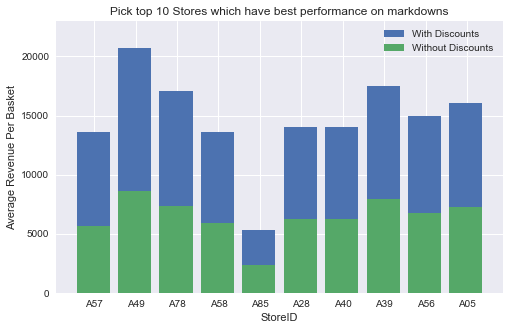

In [365]:
fig, ax = plt.subplots(figsize=(8,5))
x=np.arange(10)
width=0.05
rects1 = ax.bar(x,data73['Average sales per basket (with discounts)'][:10])
rects2 = ax.bar(x,data73['Average sales per basket (without discounts)'][:10])
ax.set_ylabel('Average Revenue Per Basket')
ax.set_xlabel('StoreID')
ax.set_ylim(0,23000)
ax.set_title('Pick top 10 Stores which have best performance on markdowns')
ax.set_xticks(x+width/2)
ax.set_xticklabels(('A57','A49','A78','A58','A85','A28','A40','A39','A56','A05'))
ax.legend((rects1[0],rects2[0]),('With Discounts','Without Discounts'))

According to the above plot, promotions will drive up average revenue per basket on a per store basis.

We pick top 10 stores that exhibited highest changes based on average sales per basket with and without discounts. We want to find out why these stores are better than others. What's going on? What might have caused it?

To gain more insights on why these stores have better performance on markdown strategies, we may gain additional data like customer's income level, demographic information (age, sex, ethnic), and geo-location of the stores. Based on the information gained from the areas where the stores are located, we can have a better understanding on how stores give their promotion strategies and why they have better proformance.




<br><br>

### 2. If a product is discounted across different stores, how are you going to evaluate the promotion strategy?
 <a name='10' />


We can calculate discount rate based on sku basis, and compare store by store performance.

Our purpose is to drive up demand and make sure the company is profitable. We don't want to give discounts unless it's necessary.  Therefore, additional data points we can collect will be **income level** in a area in each of stores. For example, in certain area, the elasticity of demand is not very high, people don't respond to the price, we don't have to give these people the discounts to drive up the demand since their income level is high.  We can also talk about **demographic information** (do they really need it), like sex, ethnic. For example, for product like Indian Spices, in an area where people are mostly non-indians, the elasticity of demand is pretty low since they don't need it. It will help store manager to understand which product to discount within a neighborhood. Also, **geo-location (zip code)** is important. Since income level and demographic are all related with geo-location.

We can also do some **experimental designs** (like A/B testing) to find out people's response to the discount campaign so that we can use this info to **segment people based on 4 groups**.   
    1) They are not going to respond even you send them a discount. (You probably shouldn't target)  
	2) People who are going to buy the product at regular price. (People love the brand, they will buy anyway)  
	3) People who are not going to buy if you don't offer a discount. (For these people, we definitely want to target them)  
	4) People who don't want to get disturbed. They choose to opt out.  

**And then we only target those people who can be persuaded throughout our coupon stragety**, but leave out the other 3 groups. With this segmentation strategy,   I am also saving moeny because I am not going to spend the money to send coupons to people who will not respond it.
	

**(a)** 

**Metrics:** Elasticity of Demand on SKU level within each store

**Calculation Method:** Percent change in average # items bought for the SKU with and without discounts per basket within each store/ Percent change in price for the SKU with and without discounts within each store



In [349]:
data_type.head()

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
0,A29,11-7270-00007-00057,36,850.000,1.000,3/11/12 00:00,A21773,
1,A29,11-7270-00007-00057,39,1500.000,1.000,3/11/12 00:00,A18009,
2,A29,11-7270-00007-00057,40,1500.000,1.000,3/11/12 00:00,A25592,
3,A29,11-7270-00007-00057,41,1600.000,1.000,3/11/12 00:00,A1449,
4,A29,11-7270-00007-00057,42,1600.000,1.000,3/11/12 00:00,A1449,


#### Calculation for each SKU across stores

In [4]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [413]:
# Select transactions with discounted items for each SKU within each Store
q = '''
    select
        a.*
    from
        data_type a
    join
       (select distinct TransactionID, SKU from data_type where Count=0) b
    on
        a.TransactionID=b.TransactionID and a.SKU=b.SKU
    order by 
        a.StoreID, a.SKU
    '''
data60 = pysqldf(q)

In [367]:
data60.head(5)

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
0,A01,12-7149-00002-00679,6,2095.000,1.000,3/12/12 00:00,A10074,
1,A01,12-7149-00002-00679,7,-357.000,0.000,3/12/12 00:00,A10074,
2,A01,12-7149-00003-00011,11,2095.000,1.000,3/12/12 00:00,A10074,
3,A01,12-7149-00003-00011,12,-436.000,0.000,3/12/12 00:00,A10074,
4,A01,12-7149-00002-00234,1,2095.000,1.000,3/12/12 00:00,A1009,


In [414]:
q = '''
    select
        a.StoreID, a.SKU, sum(a.Count)/count(distinct a.TransactionID) as 'Average_#_discounted_items_bought_for_this_SKU_per_basket'
        , sum(a.Sales)/sum(a.Count) as 'Discount_Price'
    from
        data_type a
    join
       (select distinct TransactionID, SKU from data_type where Count=0) b
    on
        a.TransactionID=b.TransactionID and a.SKU=b.SKU
    group by 
        a.StoreID, a.SKU
    '''
data61 = pysqldf(q)

In [369]:
data61.head()

,StoreID,SKU,Average_#_discounted_items_bought_for_this_SKU_per_basket,Discount_Price
0,A01,A10074,1.000,1698.500
1,A01,A1009,2.000,1400.000
2,A01,A10142,1.333,1750.000
3,A01,A10163,1.000,1400.000
4,A01,A10191,2.000,2000.000


In [415]:
q='''
    select
        a.*
    from 
        data_type a
    left join
        data60 b
    on 
        a.TransactionID=b.TransactionID and a.SKU=b.SKU 
    where 
        b.TransactionID is null
    order by
        a.StoreID, a.SKU
  '''
data62=pysqldf(q)

In [371]:
data62.head(2)

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
0,A01,12-7149-00002-00399,2,2495.000,1.000,3/12/12 00:00,A10004,
1,A01,12-7149-00002-00713,8,870.000,1.000,3/12/12 00:00,A10006,


In [416]:
q='''
    select 
        a.StoreID, a.SKU, sum(a.Count)/count(distinct a.TransactionID) as 'Average_#_items_bought_at_regular_price_for_this_SKU_per_basket'
        , sum(a.Sales)/sum(a.Count) as 'Regular_Price'
    from
        data62 a
    group by 
        a.StoreID, a.SKU
'''
data63=pysqldf(q)

In [373]:
data63.head()

,StoreID,SKU,Average_#_items_bought_at_regular_price_for_this_SKU_per_basket,Regular_Price
0,A01,A10004,1.000,2495.000
1,A01,A10006,1.000,870.000
2,A01,A10023,1.000,695.000
3,A01,A10024,1.000,4695.000
4,A01,A10048,3.000,1395.000


In [417]:
q='''
    select
        a.StoreID, a.SKU, 
        (abs(a.'Average_#_discounted_items_bought_for_this_SKU_per_basket'-b.'Average_#_items_bought_at_regular_price_for_this_SKU_per_basket')/
        b.'Average_#_items_bought_at_regular_price_for_this_SKU_per_basket') /
        (abs(a.Discount_Price-b.Regular_Price)/b.Regular_Price) as 'Elasticity_of_Demand'
    from
        data61 a
    join
        data63 b
    on
        a.StoreID=b.StoreID and a.SKU=b.SKU
'''
data64=pysqldf(q)

In [404]:
data64.head()

,StoreID,SKU,Elasticity_of_Demand
0,A01,A10191,5.040
1,A01,A10206,3.937
2,A01,A10259,4.419
3,A01,A10415,14.285
4,A01,A10416,0.000


In [376]:
data61[(data61.StoreID=='A01')&(data61.SKU=='A10416')]

,StoreID,SKU,Average_#_discounted_items_bought_for_this_SKU_per_basket,Discount_Price
9,A01,A10416,1.000,1500.000


In [377]:
data63[(data63.StoreID=='A01')&(data63.SKU=='A10416')]

,StoreID,SKU,Average_#_items_bought_at_regular_price_for_this_SKU_per_basket,Regular_Price
36,A01,A10416,1.000,1700.000


In [418]:
data65 = data64.sort_values(['Elasticity_of_Demand'], ascending=[False])

In [420]:
data65.describe()

,Elasticity_of_Demand
count,13679.000
mean,6.343
std,47.939
min,0.000
25%,0.000
50%,2.933
75%,6.102
max,3600.000


The Elasticity of Demand ranges from 0 to 3600, the median is 2.9 and the 75 percentile is 6.1.

In [430]:
print data65[data65['Elasticity_of_Demand']<10]['Elasticity_of_Demand'].count()
print data65[data65['Elasticity_of_Demand']>=10]['Elasticity_of_Demand'].count()

11817
1862


How many Elasticity of Demand are above 10 --> 1862  
How many Elasticity of Demand are below 10 --> 11817


In [422]:
data65.head(5)

,StoreID,SKU,Elasticity_of_Demand
9346,A56,A11941,3600.000
7012,A42,A13411,3301.500
8961,A52,A21408,1100.000
91,A01,A17834,751.000
11404,A71,A9910,751.000


In [410]:
data_type[(data_type.StoreID=='A71')&(data_type.SKU=='A9910')]

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
869619,A71,12-6797-00003-00021,4,1502.000,1.000,3/12/12 00:00,A9910,
870898,A71,12-6797-00001-00325,1,1502.000,1.000,3/12/12 00:00,A9910,
878264,A71,12-6797-00004-00453,8,1502.000,1.000,3/12/12 00:00,A9910,
878265,A71,12-6797-00004-00453,9,-2.000,0.000,3/12/12 00:00,A9910,
878266,A71,12-6797-00004-00453,10,1502.000,1.000,3/12/12 00:00,A9910,
878267,A71,12-6797-00004-00453,11,-2.000,0.000,3/12/12 00:00,A9910,


In [425]:
len(data65.loc[data65['Elasticity_of_Demand']==0])

3705

In [431]:
# We determine to look at SKUs where Elasticity_of_Demand < 10
data66 = data65.loc[data65['Elasticity_of_Demand']<10]

In [432]:
data66.head()

,StoreID,SKU,Elasticity_of_Demand
11409,A72,A11919,9.999
5924,A34,A24899,9.999
803,A06,A24899,9.999
11342,A71,A3531,9.996
7444,A43,A3531,9.994


In [142]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [434]:
def autolabel(ax):
    for rect in ax.patches:
        height=rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2, 1.05*height, '{:.2f}'.format(height), ha='center', va='bottom')

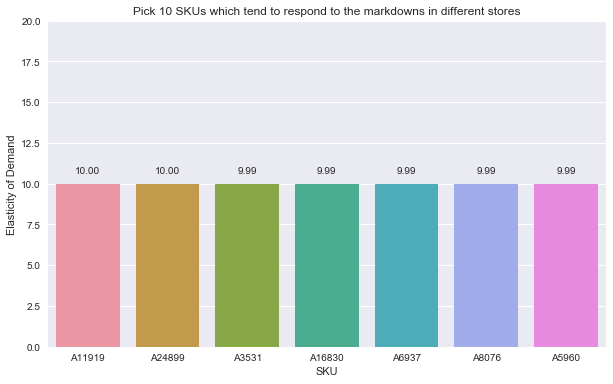

In [436]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x='SKU',y='Elasticity_of_Demand',data=data66[:10])
plt.ylabel('Elasticity of Demand')
plt.ylim(0,20)
plt.title('Pick 10 SKUs which tend to respond to the markdowns in different stores')
autolabel(ax)

<br><br>

**(b)** 

**Metrics:** Proportion of the SKU when (not) discounted within a store

**Calculation Method:** # (not discounted) discounted items bought for this SKU within a store / Total # items bought across transactions with (without) discounted items for this SKU within a store



In [246]:
data60.head()

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
0,A01,12-7149-00002-00679,6,2095.000,1.000,3/12/12 00:00,A10074,
1,A01,12-7149-00002-00679,7,-357.000,0.000,3/12/12 00:00,A10074,
2,A01,12-7149-00003-00011,11,2095.000,1.000,3/12/12 00:00,A10074,
3,A01,12-7149-00003-00011,12,-436.000,0.000,3/12/12 00:00,A10074,
4,A01,12-7149-00002-00234,1,2095.000,1.000,3/12/12 00:00,A1009,


In [437]:
q='''
    select
       a.StoreID, a.TransactionID, sum(a.Count) as 'Total_#_items_bought'
    from data_type a
    join (select distinct TransactionID from data60) b
    on a.TransactionID=b.TransactionID
    group by a.TransactionID
'''
data67=pysqldf(q)

In [439]:
data67.head(3)

,StoreID,TransactionID,Total_#_items_bought
0,A60,11-0160-00019-00003,10.000
1,A60,11-0160-00019-00007,15.000
2,A60,11-0160-00019-00008,15.000


In [438]:
q='''
    select
       StoreID, TransactionID, SKU, sum(Count) as '#_discounted_items_bought_for_this_SKU'
    from data60
    group by TransactionID, SKU
    
'''
data68=pysqldf(q)

In [440]:
data68.head(3)

,StoreID,TransactionID,SKU,#_discounted_items_bought_for_this_SKU
0,A60,11-0160-00019-00003,A10809,10.000
1,A60,11-0160-00019-00007,A10809,10.000
2,A60,11-0160-00019-00007,A15452,5.000


In [459]:
q='''
    select
       a.StoreID, b.SKU, sum(b.'#_discounted_items_bought_for_this_SKU')/sum(a.'Total_#_items_bought') as 
       'Proportion_of_this_SKU_when_discounted'
    from data67 a
    join data68 b
    on a.TransactionID=b.TransactionID
    group by a.StoreID, b.SKU
    
'''
data69=pysqldf(q)

In [460]:
data69.head(6)

,StoreID,SKU,Proportion_of_this_SKU_when_discounted
0,A01,A10074,0.250
1,A01,A1009,1.000
2,A01,A10142,0.125
3,A01,A10163,0.167
4,A01,A10191,0.226
5,A01,A10206,0.529


<br>

In [443]:
data62.head(3)

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
0,A01,12-7149-00002-00399,2,2495.000,1.000,3/12/12 00:00,A10004,
1,A01,12-7149-00002-00713,8,870.000,1.000,3/12/12 00:00,A10006,
2,A01,12-7149-00009-00067,19,870.000,1.000,3/12/12 00:00,A10006,


In [444]:
q='''
    select
     a.StoreID, a.TransactionID, a.SKU, sum(Count) as '#_regular_price_items_bought_for_this_SKU'
    from data62 a
    join (select distinct StoreID, SKU from data69) b
    on a.StoreID=b.StoreID and a.SKU=b.SKU
    group by a.StoreID, a.TransactionID, a.SKU
    
'''
data610=pysqldf(q)

In [445]:
data610.head(3)

,StoreID,TransactionID,SKU,#_regular_price_items_bought_for_this_SKU
0,A01,12-7149-00001-00006,A20796,1.000
1,A01,12-7149-00001-00006,A25676,1.000
2,A01,12-7149-00001-00012,A15495,1.000


In [446]:
q='''
    select
       a.StoreID, a.TransactionID, sum(a.Count) as 'Total_#_items_bought'
    from data_type a
    join (select distinct TransactionID from data610) b
    on a.TransactionID=b.TransactionID
    group by a.TransactionID
'''
data611=pysqldf(q)

In [447]:
data611.head(3)

,StoreID,TransactionID,Total_#_items_bought
0,A60,11-0160-00019-00011,16.000
1,A60,11-0160-00019-00032,6.000
2,A60,11-0160-00021-00008,1.000


In [462]:
q='''
    select
       a.StoreID, a.SKU, sum(a.'#_regular_price_items_bought_for_this_SKU')/sum(b.'Total_#_items_bought') as 
       'Proportion_of_this_SKU_when_not_discounted'
    from data610 a
    join data611 b
    on a.TransactionID=b.TransactionID
    group by a.StoreID, a.SKU
    
'''
data612=pysqldf(q)

<br>

#### Proportion of the SKU when not discounted on Store Level

In [463]:
data612.head()

,StoreID,SKU,Proportion_of_this_SKU_when_not_discounted
0,A01,A10191,0.105
1,A01,A10206,0.857
2,A01,A10259,0.111
3,A01,A10415,0.100
4,A01,A10416,0.158


#### Proportion of the SKU when  discounted on Store Level

In [464]:
data69.head()

,StoreID,SKU,Proportion_of_this_SKU_when_discounted
0,A01,A10074,0.250
1,A01,A1009,1.000
2,A01,A10142,0.125
3,A01,A10163,0.167
4,A01,A10191,0.226


<br>

In [467]:
q='''
    select a.StoreID, a.SKU, b.'Proportion_of_this_SKU_when_not_discounted',a.'Proportion_of_this_SKU_when_discounted'
    from data69 a
    join data612 b
    on a.StoreID=b.StoreID and a.SKU=b.SKU
    order by a.StoreID, a.SKU
    
'''
data613=pysqldf(q)

In [469]:
data613.head()

,StoreID,SKU,Proportion_of_this_SKU_when_not_discounted,Proportion_of_this_SKU_when_discounted
0,A01,A10191,0.105,0.226
1,A01,A10206,0.857,0.529
2,A01,A10259,0.111,0.408
3,A01,A10415,0.100,0.333
4,A01,A10416,0.158,0.154


In [471]:
data613.describe()

,Proportion_of_this_SKU_when_not_discounted,Proportion_of_this_SKU_when_discounted
count,13783.000,13813.000
mean,0.221,0.247
std,0.240,0.231
min,0.000,0.003
25%,0.087,0.105
50%,0.133,0.167
75%,0.250,0.286
max,1.000,1.000


The median of 'Proportion_of_the_SKU_when_discounted' (16.7%) is a little bit higher than the median of 'Proportion_of_the_SKU_when_not_discounted' (13.3%).

<br><br>

### 3. Can we find any cross-sell and up-sell opportunites? <a name='11' />

**Metrics:** support, confidence, lift 

**Calculation Method:** We pick top 5 stores based on markdowns performance calculated from the first question. Within each store, we can use association anlysis to find some relationships between 2 products or 2 groups, and use support, confidence, lift to find out what products tend to be purchased together.


In [53]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [433]:
data_type = pd.read_csv('data_type.csv')
data_type.fillna('',inplace=True)

In [443]:
data_type[(data_type.TransactionID=='11-7270-00007-00089')&(data_type.SKU=='A21166')]

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
610,A29,11-7270-00007-00089,4,3995.000,1.000,3/11/12 00:00,A21166,
616,A29,11-7270-00007-00089,19,-3995.000,-1.000,3/11/12 00:00,A21166,Regular_Return
617,A29,11-7270-00007-00089,20,1995.000,1.000,3/11/12 00:00,A21166,


In [62]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

In [72]:
def associationAnalysis(Store):
    basket = data_type[data_type['StoreID']==Store].groupby(['TransactionID','SKU'])['Count'].sum().unstack().reset_index().fillna(0).set_index('TransactionID')
    basket_sets = basket.applymap(encode_units)
    frequent_itemsets = apriori(basket_sets, min_support=0.005, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    rules = rules.sort_values(['lift'],ascending=[False])
    print rules.head(6)

<br>

In [73]:
associationAnalysis('A57')

   antecedants consequents  support  confidence   lift
0      (A9771)     (A4107)    0.031       0.192 23.214
1      (A4107)     (A9771)    0.008       0.714 23.214
19     (A1449)     (A2341)    0.012       0.600 22.043
18     (A2341)     (A1449)    0.027       0.261 22.043
4      (A2341)     (A9771)    0.027       0.304  9.891
5      (A9771)     (A2341)    0.031       0.269  9.891


#### In store A57, for example, {A4107}-->{A9771}:
- 0.8% support means 0.8% proportion of transactions in the dataset contain both A4107 and A9771;   
- 71.4% confidence means 71.4% who buy A4107 will also buy A9771.   
- Since lift=23.214 which lets us know it is a large degree that the occurences of A4107 are dependent on A9771.  

#### So we conclude that A4107 and A9771, A2341 and A1449, A9771 and A2341 can be cross selled togther in Store A57.

<br>

In [74]:
associationAnalysis('A49')

   antecedants consequents  support  confidence   lift
31    (A20578)     (A3765)    0.013       0.419 20.863
30     (A3765)    (A20578)    0.020       0.271 20.863
15     (A9946)     (A5821)    0.005       1.000 19.415
29    (A24233)     (A5821)    0.006       1.000 19.415
28     (A5821)    (A24233)    0.052       0.122 19.415
9      (A6041)     (A5821)    0.007       1.000 19.415


#### In Store A49, we conclude that A20578 and A3765, A9946 and A5821, A24233 and A5821 can be cross selled togther.

<br>

In [75]:
associationAnalysis('A58')

  antecedants consequents  support  confidence  lift
4     (A9353)     (A4023)    0.175       0.035 4.083
5     (A4023)     (A9353)    0.009       0.714 4.083
0     (A9353)    (A25659)    0.175       0.035 3.573
1    (A25659)     (A9353)    0.010       0.625 3.573
3     (A9353)    (A11124)    0.175       0.035 3.176
2    (A11124)     (A9353)    0.011       0.556 3.176


#### In Store A58, we conclude that A9353 and A4023, A9353 and A25659, A9353 and A11124 can be cross selled togther.

<br>

In [76]:
associationAnalysis('A78')

   antecedants consequents  support  confidence   lift
12    (A10644)    (A10809)    0.011       0.985 26.172
13    (A10809)    (A10644)    0.038       0.293 26.172
6      (A1449)    (A25312)    0.013       0.408  8.294
7     (A25312)     (A1449)    0.049       0.105  8.294
15    (A25312)     (A2341)    0.049       0.214  6.310
14     (A2341)    (A25312)    0.034       0.310  6.310


#### In Store A78, we conclude that A10644 and A10809, A1449 and A25312, A2341 and A25312 can be cross selled togther.

<br>

In [78]:
associationAnalysis('A85')

                         antecedants       consequents  support  confidence  \
733                  (A10809, A3664)  (A10644, A13046)    0.005       1.000   
467                          (A7260)  (A10644, A24233)    0.005       1.000   
470   (A5821, A7260, A10644, A10809)          (A24233)    0.005       1.000   
473  (A5821, A10644, A10809, A24233)           (A7260)    0.005       1.000   
475           (A5821, A7260, A10644)  (A10809, A24233)    0.005       1.000   
476           (A5821, A7260, A10809)  (A10644, A24233)    0.005       1.000   

       lift  
733 182.000  
467 182.000  
470 182.000  
473 182.000  
475 182.000  
476 182.000  


#### In Store A85, we can cross sell (A10809, A3664) with (A10644, A13046) and (A7260) with (A1064, A24233).

<br><br>

### 4. How about the time or day of promotion? Would that make a difference? <a name='12' />


**Metrics:** Average sales per basket on transactions with and without discounted items within a store for each DATE 

**Calculation Method:** 'Sum of sales / number of transactions' for  transactions with discounted items, and transactions without discounted items for SPECIFIC DATE within a store. And then compare the average sales per basket. Also check whether promotions on different dates would make a difference. 


In [75]:
data50.head(3)

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
0,A29,11-7270-00007-00057,36,850.0,1.0,3/11/12 00:00,A21773,
1,A29,11-7270-00007-00057,39,1500.0,1.0,3/11/12 00:00,A18009,
2,A29,11-7270-00007-00057,40,1500.0,1.0,3/11/12 00:00,A25592,


In [309]:
# Select transactions with discounted items for specific store
q='''
  select
      StoreID,
      Date,
      count(distinct TransactionID) as Number_of_Transactions,
      sum(Sales)/count(distinct TransactionID) as 'Average_sales_per_basket_with_discounts'
  from
      data50
  group by
      StoreID, Date
  
  '''
data80= pysqldf(q)

In [311]:
data80.head(3)

,StoreID,Date,Number_of_Transactions,Average_sales_per_basket_with_discounts
0,A01,3/12/12 00:00,1119,10503.609
1,A02,3/12/12 00:00,515,17329.019
2,A03,3/12/12 00:00,614,16190.534


In [310]:
# Select transactions with discounted items for specific store
q='''
  select
      StoreID,
      Date,
      count(distinct TransactionID) as Number_of_Transactions,
      sum(Sales)/count(distinct TransactionID) as 'Average_sales_per_basket_without_discounts'
  from
      data52
  group by
      StoreID, Date
  '''
data81= pysqldf(q)

In [312]:
data81.head(3)

,StoreID,Date,Number_of_Transactions,Average_sales_per_basket_without_discounts
0,A01,3/12/12 00:00,2323,5276.603
1,A02,3/12/12 00:00,1212,8966.672
2,A03,3/12/12 00:00,1145,7716.802


In [314]:
# Select transactions with discounted items for specific store
q='''
  select
      a.StoreID, a.Date, a.'Average_sales_per_basket_with_discounts', b.'Average_sales_per_basket_without_discounts'
  from
      data80 a
  join 
      data81 b
  on
      a.StoreID=b.StoreID and a.Date=b.Date
  '''
data82= pysqldf(q)

In [318]:
data82.head()

,StoreID,Date,Average_sales_per_basket_with_discounts,Average_sales_per_basket_without_discounts
0,A01,3/12/12 00:00,10503.609,5276.603
1,A02,3/12/12 00:00,17329.019,8966.672
2,A03,3/12/12 00:00,16190.534,7716.802
3,A05,3/12/12 00:00,16058.825,7252.021
4,A06,3/12/12 00:00,10959.196,5615.334


In [320]:
data82['Date'].value_counts()

3/12/12 00:00    70
3/11/12 00:00    15
Name: Date, dtype: int64

In [502]:
print len(data_type[data_type['Date']=='3/11/12 00:00']['StoreID'].unique())
print len(data_type[data_type['Date']=='3/12/12 00:00']['StoreID'].unique())
print len(data_type['StoreID'].unique())

15
70
73


In [496]:
data82[data82['Date']=='3/11/12 00:00'].describe()

,Average_sales_per_basket_with_discounts,Average_sales_per_basket_without_discounts
count,15.000,15.000
mean,7674.980,3834.138
std,5223.690,2323.669
min,3061.765,1810.857
25%,4745.737,2348.988
50%,4977.198,2674.846
75%,9068.698,5031.048
max,17674.746,8511.883


In [495]:
data82[data82['Date']=='3/12/12 00:00'].describe()

,Average_sales_per_basket_with_discounts,Average_sales_per_basket_without_discounts
count,70.000,70.000
mean,14654.122,7384.158
std,2597.668,1114.004
min,8430.659,5276.603
25%,12870.756,6480.872
50%,14858.789,7502.973
75%,16255.251,8148.794
max,20754.742,10258.552


On 3/11/12 (Sunday), the mean of 'average sales per basket without discounts' is \$3834, and the mean of 'average sales per basket with discounts' is \$7674. 

On 3/12/12 (Monday), the mean of 'average sales per basket without discounts' is \$7384, and the mean of 'average sales per basket with discounts' is \$14654. 

That means no matter with or without the discount campaign, the average sales per basket is higher on 3/12/12 than on 3/11/12.

In [475]:
# Check which stores have two dates in the dataframe
Series1 = data82.duplicated(subset=['StoreID'])
list1=[i for i,x in enumerate(Series1) if x]
data82.iloc[list1].head(4)

,StoreID,Date,Average_sales_per_basket_with_discounts,Average_sales_per_basket_without_discounts
16,A17,3/12/12 00:00,18624.519,8587.230
18,A19,3/12/12 00:00,13874.132,6608.535
27,A27,3/12/12 00:00,15330.352,7931.393
30,A29,3/12/12 00:00,18137.361,9383.987


In [493]:
data82.iloc[list1].shape

(12, 4)

In [334]:
data83 = data82[data82['StoreID']=='A17']
data83

,StoreID,Date,Average_sales_per_basket_with_discounts,Average_sales_per_basket_without_discounts
15,A17,3/11/12 00:00,4977.198,3189.108
16,A17,3/12/12 00:00,18624.519,8587.230


In [476]:
data84 = data82[data82['StoreID']=='A19']
data85 = data82[data82['StoreID']=='A27']
data86 = data82[data82['StoreID']=='A29']

In [331]:
np.arange(2)

array([0, 1])

In [481]:
def autolabel(rects):
    for rect in rects:
        height=rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2, 1.05*height, '{:.2f}'.format(height), ha='center', va='bottom')

In [491]:
def draw_plot(data):
    fig, ax = plt.subplots(figsize=(8,5))
    #x=np.arange(2)
    x=np.array([0,2])
    width=0.05
    rects1 = ax.bar(x,data['Average_sales_per_basket_with_discounts'])
    rects2 = ax.bar(x+0.8,data['Average_sales_per_basket_without_discounts'])
    ax.set_ylabel('Average Revenue Per Basket')
    ax.set_xlabel('Date')
    ax.set_ylim(0,22000)
    ax.set_title('Average sales per basket with and without discounts for different date in Store A19')
    ax.set_xticks(x+0.4)
    ax.set_xticklabels(('3/11/12','3/12/12'))
    ax.legend((rects1[0],rects2[0]),('With Discounts','Without Discounts'))
    autolabel(rects1)
    autolabel(rects2)


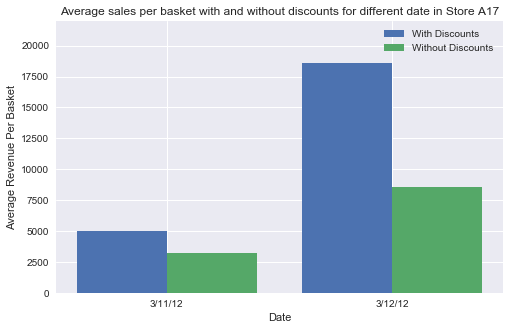

In [490]:
draw_plot(data83)

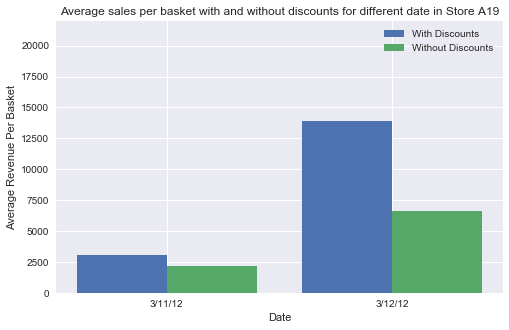

In [492]:
draw_plot(data84)

<br><br>

### 5. Look at low end and high end products separately when evaluating promotion strategy <a name='13' />


We define high end products are those whose regular unit price is bigger than \$5000. And low end products are those whose regular unit price is lower than $300.

**Metrics:** Elasticity of Demand for specific SKU within a store


**Explanation:** I would make my own buckets and define which SKUs are high-end products, and which SKUs are low-end products. Then I would look at low end and high end produtcs separetely by calculating elasticity of demand for each SKU within a store.


In [503]:
# Select high end products
q='''
  select distinct StoreID, SKU
  from data_type
  where Count>0 and Sales/Count>5000
  '''
data90= pysqldf(q)

In [132]:
data_type[data_type.SKU=='A22173'].head(3)

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
232,A29,11-7270-00008-00386,30,19900.0,1.0,3/11/12 00:00,A22173,
6378,A29,11-7270-00006-00053,1,19900.0,1.0,3/11/12 00:00,A22173,
11728,A29,11-7270-00006-00331,19,19900.0,1.0,3/11/12 00:00,A22173,


In [512]:
#SKUs with elasticity
data65.head()

,StoreID,SKU,Elasticity_of_Demand
9346,A56,A11941,3600.000
7012,A42,A13411,3301.500
8961,A52,A21408,1100.000
91,A01,A17834,751.000
11404,A71,A9910,751.000


In [513]:
q='''
  select b.*
  from data90 a
  join data65 b
  on a.SKU=b.SKU and a.StoreID=b.StoreID
  '''
data91= pysqldf(q)

In [514]:
data91.describe()

,Elasticity_of_Demand
count,256.000
mean,25.780
std,227.336
min,0.000
25%,1.542
50%,5.476
75%,12.999
max,3600.000


<br>

In [507]:
# Select low end products
q='''
  select distinct StoreID, SKU
  from data_type
  where Count>0 and Sales/Count<300
  '''
data92= pysqldf(q)

In [515]:
q='''
  select b.*
  from data92 a
  join data65 b
  on a.SKU=b.SKU and a.StoreID=b.StoreID
  '''
data93= pysqldf(q)

In [516]:
data93.head(3)

,StoreID,SKU,Elasticity_of_Demand
0,A19,A6647,37.162
1,A02,A16896,7.278
2,A05,A16896,43.667


In [517]:
data93.describe()

,Elasticity_of_Demand
count,67.000
mean,37.251
std,36.023
min,0.000
25%,9.938
50%,25.475
75%,65.500
max,196.500


In [518]:
print data91.shape #high-end products
print data93.shape #low-end products

(276, 3)
(69, 3)


For low-end products, elasticity of demand ranges from 0 to 196. Median is 25 and 75 percentile of elasticity of demand is 65. 

For high-end products, elasticity of demand ranges from 0 to 3600. Median is 5.5 and 75 percentile of elasticity of demand is 13. 